<a href="https://colab.research.google.com/github/bksaini078/fake_news_detection/blob/master/MeanTeacher/MT_unlabelled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author: Bhupender Kumar Saini**

As Mean squared difference between student and teacher model output distribution as consis-tency cost during training student model. It’s assumed that unlabeled data will be having truedistribution same as label data. By adding distribution difference while training, model tries toreduce the difference between student and teacher output distribution. The same distributiondifference has been implemented in VAT regularisation techniques

# Declaring Libraries 





In [ ]:
#please install contractions 
import numpy as np
import re
import nltk
# import contractions
import string
import pandas as pd
import os
import numpy as np
import random
import spacy
import time
import re
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils 
from gensim.test.utils import get_tmpfile
from nltk.corpus import stopwords
import nltk
import en_core_web_sm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

# nlp = en_core_web_sm.load()
# nltk.download('stopwords')
# nltk.download('punkt')
# porter=PorterStemmer()


In [ ]:
import tensorflow as tf 

import tensorflow.keras as tfk
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
import numpy as np
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
#this is to enable eager execution
tf.compat.v1.enable_eager_execution()
path = '/content/drive/My Drive/Colab Notebooks/LatestData_July'
# path = '/content/drive/My Drive/Colab Notebooks/lokesh_data'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Tokenization

In [ ]:
def tokenization(x_train, x_test, x_unlabel, maxlen):

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing import sequence
    import numpy as np

    # max_features = 20000
    # maxlen = 100
    # batch_size = 32

    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ',
                          char_level=False, oov_token=None, document_count=0)
    full_article = np.hstack((x_train, x_test, x_unlabel))
    tokenizer.fit_on_texts(full_article)
    x_train_token = tokenizer.texts_to_sequences(x_train)
    x_test_token = tokenizer.texts_to_sequences(x_test)
    x_unlabel_token = tokenizer.texts_to_sequences(x_unlabel)
    x_train_seq = sequence.pad_sequences(x_train_token, maxlen=maxlen,padding='post')
    x_test_seq = sequence.pad_sequences(x_test_token, maxlen=maxlen,padding='post')
    x_unlabel_tar= sequence.pad_sequences(x_unlabel_token, maxlen=maxlen,padding='post')
    # defining vocalbury size
    vocab_size = len(tokenizer.word_index) + 1

    x_train = x_train_seq
    x_test = x_test_seq
    return x_train, x_test , x_unlabel_tar, vocab_size, tokenizer

# Noise Creator 

In [ ]:
def instant_noise(x_train, y_train, x_unlabel, n_ratio ):
    '''this function introduce noise in the training data for mean teacher model , 
    this function is used in calculating classification cost, user have to provide 
    amount of noise, want to add(ratio) in train data and test train split ratio too'''
    #amount of noise need to add in x_train data 
    noise=int(np.shape(x_train)[0]*n_ratio)
 
    # taking column of x_train, need it later 
    x_column = np.shape(x_train)[1]

    if noise <= int(np.shape(x_unlabel)[0]):

        #taking number of noise from unlabel data 
        ratio_noise = x_unlabel[:noise]

        # creating -1 label for noise data 
        y_unlabel=np.full((np.shape(ratio_noise)[0], 1), -1)

        # adding noise in train data 
        x = np.append(x_train, ratio_noise, axis=0)
        # print(np.shape(x))
        y = np.append(y_train, y_unlabel, axis=0)
        x = np.append(x,y, axis=1)
        row = np.shape(x)[0]

        # shufflin data 
        x =np.random.permutation(x)
        # print(np.shape(x))

        #seperating label from x 
        y_train_n=np.reshape(x[:,x_column],(row,1))
        x_train_n=x[0:len(x),0:x_column]
        # y_train_n= np.reshape(y[:len(x),0],(train_split,1))

        
    else :
        print('error: Insufficient unlabel data available !')

    return x_train_n, y_train_n


In [ ]:
from tensorflow.keras.preprocessing import sequence
from nltk import WordPunctTokenizer
from gensim.models.fasttext import FastText

def embedding_creation(full_article):
    word_punctuation_tokenizer = nltk.WordPunctTokenizer()
    word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in full_article]
    embedding_size = 60
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    embedd_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=0,
                      iter=50)
    print('Finished and saving model at location', path)
    embedd_model.save(path+'embedding_Model.model')
    return 


def synonym_noise(x_batch,maxlen,tokenizer):
    articles = tokenizer.sequences_to_texts(x_batch)
    changed_articles=[]
    model_embedd= FastText.load( path+'/embedding.model')
    for article in articles:
        word_array= article.split(' ')
        sent1=[]
        '''toss and taking random decision on data'''
        if np.random.binomial(1, 0.5):
            for word in word_array:
                if word in model_embedd.wv.vocab:
                    most_similar=model_embedd.wv.most_similar(word)
                    # print(most_similar[0][0])
                    #flipping coin to decide to change or not if head change word and if tails dont change
                    #change p value for reducing or increasing the edit 
                    if np.random.binomial(1, 0.3):
                        sent1.append(most_similar[0][0])
                    else:
                        sent1.append(word)
                else:
                    sent1.append(word)
            joined_text = ' '.join(sent1)
        else:
            joined_text=' '.join(word_array)
        changed_articles.append(joined_text)
    x_train_seq_n = tokenizer.texts_to_sequences(changed_articles)
    x_train_seq_n = sequence.pad_sequences(x_train_seq_n,maxlen=maxlen)
    x_train_seq_n=tf.convert_to_tensor(x_train_seq_n)
    return x_train_seq_n

# Model Declaration



In [ ]:
def BiLstmModel(maxlen, vocab_size):
  tf.keras.backend.clear_session()
  inputs = keras.Input(shape=(maxlen,))
  x =Embedding(vocab_size, 128, input_length=None)(inputs)
  x =Bidirectional(LSTM(128))(x)
#   x = Dropout(0.2)(x)
#   x =Dense(64,activation='relu')(x)
  x =Dense(2)(x)
  x =Dense(1, activation='sigmoid')(x)
  return Model(inputs,x)


# Evaluation Functions

In [ ]:

#Function to create confusion matrix 
def Confusion_matrix(model,x_test,y_true, threshold, caption='Confusion matrix'):
    '''this function will create confusion matrix with predicted value and true label'''
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,threshold)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    # print(cm)
    # calculating recall , precision and f1 score 
    tp_and_fp=np.sum(cm[:,1])
    tn_and_fp=np.sum(cm[0,:])
    tp_and_fn = np.sum(cm[1, : ])
    tp_and_tn= np.trace(cm)
    tp=(tp_and_fp-tn_and_fp+tp_and_tn)/2
    '''handling with divide by zero is pending'''
    #TODO: handling of divide by zero 
    precision=tp/tp_and_fp 
    recall = tp/tp_and_fn
    accuracy= np.trace(cm)/np.sum(cm)
    # f1_score=sklearn.metrics.f1_score(y_true, y_pred)
    f1_score= (2*precision*recall)/(precision+recall)
    print('Precision:', precision)
    print('Recall:', recall)
    print('f1 Score:', f1_score)
    print('Accuracy:', accuracy)

    # import matplotlib.pyplot as plt
    # figure = plt.figure(figsize=(8, 8))
    # # cm=np.around(cm.astype(int))
    # # con_mat_norm = np.around(cm, decimals=4)
    # con_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Oranges)
    # plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.title(caption)
    
    # plt.show()
    return cm, accuracy, precision, recall, f1_score
def prec_rec_f1score(y_true,x_test,model):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    bce = tf.keras.losses.BinaryCrossentropy()
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,0.51)).astype(int)
    pr_re_f1score_perclass= precision_recall_fscore_support(y_true, y_pred, average=None)
    pr_re_f1score_average=precision_recall_fscore_support(y_true, y_pred, average='micro')
    precision=precision_score(y_true,y_pred,average=None)
    recall = recall_score(y_true,y_pred,average=None)
    accuracy= accuracy_score(y_true,y_pred)
    f1_score=f1_score(y_true,y_pred)
    #per class
    precision_true=pr_re_f1score_perclass[0][1]
    precision_fake=pr_re_f1score_perclass[0][0]
    recall_true=pr_re_f1score_perclass[1][1]
    recall_fake=pr_re_f1score_perclass[1][0]
    f1score_true= pr_re_f1score_perclass[2][1]
    f1score_fake= pr_re_f1score_perclass[2][0]
    metrices_name=['accuracy','precision_true','precision_fake','recall_true','recall_fake','f1score_true','f1score_fake']
    metrices_value=[accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake]
    i=0
    for item in metrices_name:
        print(item +':' ,metrices_value[i])
        i+=1
    binary_loss= bce(y_true, y_hat).numpy()
    print('Binary_loss',binary_loss)

    return accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake,binary_loss 


In [ ]:
import matplotlib.pyplot as plt
def scatter_plot(logits, y_t, title):
    marker_size=20
    figure = plt.figure(figsize=(20, 6))
    plt.scatter(logits,logits, marker_size, c=y_t)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Predicted Probability")
    cbar= plt.colorbar()
    cbar.set_label("Probability", labelpad=+1)
    plt.show()
    return

# accuracy 
def model_evaluation(model, x_test, y_true, name):
    y_hat= model(x_test)
    y_pred=(np.greater(y_hat,0.505)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    
    accuracy= np.trace(cm)/np.sum(cm)
    
    print(name+ ":")
  
    print(' Accuracy:', accuracy)

    # this will plot the result 
    # scatter_plot(y_hat,y_true, title=name)

    return accuracy #precision, recall, f1_score, accuracy
def plot_roc(fpr,tpr,label):
    #  plot the roc curve for the model
    pyplot.plot(fpr, tpr, linestyle='--', label=label)

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot 
    pyplot.show()
    return

# Cost Functions

In [ ]:
# declaring loss function
# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
def classification_costs(logits, labels):
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating 
    the binary cross entropy .
    """
    applicable = tf.not_equal(labels, -1)

     # Change -1s to zeros to make cross-entropy computable
    labels = tf.where(applicable, labels, tf.zeros_like(labels))

    # This will now have incorrect values for unlabeled examples
    per_sample = tf.keras.losses.binary_crossentropy(labels,logits)
    # Retain costs only for labeled
    per_sample = tf.where(applicable, per_sample, tf.zeros_like(per_sample))
    # Take mean over all examples, not just labeled examples.
   
    loss = tf.math.divide( tf.reduce_mean(tf.reduce_sum(per_sample)), np.shape(per_sample)[0])

    return loss

#custom loss function
def Overall_Cost(classification_cost, consistency_cost, ratio=0.5):
    return (ratio * classification_cost) + ((1 - ratio)*consistency_cost)
#function for consistency cost 
def Consistency_Cost(teacher_output, student_output):
    #Kl divergence 
    # kl = tf.keras.losses.KLDivergence()
    # sq_diff_layer=kl(teacher_output, student_output).numpy()
    
    #MSE
    sq_diff_layer = tf.reduce_mean(tf.math.squared_difference(teacher_output, student_output))
    return sq_diff_layer
def ema(student_model, teacher_model, alpha):
    '''
    Calculates the exponential moving average of the student model weights and updates the teacher model weights
    formula:
    t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with default alpha = 0.99
    t_i = weights of teacher model in current epoch
    s_i = weights of student model in current epoch
    '''
    #taking weights 
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    #length must be equal otherwise it will not work 
    assert len(student_weights) == len(teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(
        len(student_weights), len(teacher_weights))

    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha*(teacher_weights[i]) + (1-alpha)*layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model


# Writing Report

In [ ]:

def report_writing(Model,lr,Batch_Size, Epoch,Alpha,Ratio, train_accuracy,test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,Classification_Loss,comment):
    x = datetime.datetime.now()
    report_df = pd.DataFrame(columns=['Date', 'Model','Learning Rate','Batch_Size', 'Epoch','Alpha','Ratio','Train_Accuracy',
                                      'Test_Accuracy', 'Precision_True','Precision_Fake','Recall_True','Recall_Fake','F1_Score_True','F1_Score_Fake','Classification_Loss',
                                      'comment'])
    report_df = report_df.append({'Date' : x.strftime("%c"), 'Model' :Model,'Learning Rate':lr,'Batch_Size' : Batch_Size, 'Epoch': Epoch,'Alpha': Alpha,'Ratio': Ratio,'Train_Accuracy': train_accuracy,
                                  'Test_Accuracy': test_accuracy, 'Precision_True': precision_true,'Precision_Fake': precision_fake,'Recall_True': recall_true,'Recall_Fake': recall_fake,'F1_Score_True': f1score_true,'F1_Score_Fake': f1score_fake, 'Classification_Loss':Classification_Loss,'comment': comment}, ignore_index=True)
    my_file = Path(path+'/report_synonym_unlabelledDifference_0.99_10fold_2.csv')

    if my_file.exists():
        report_df.to_csv(path+'/report_synonym_unlabelledDifference_0.99_10fold_2.csv',mode='a', header= False , index = False)
    else:
        report_df.to_csv(path+'/report_synonym_unlabelledDifference_0.99_10fold_2.csv',mode='w', header= True , index= False) 
    return 

# report_writing('Supervised-BiLstm', 124,10,34, 0.5, 0.99,0.90,0.90,0.90)

# Loading data 

In [ ]:

def loading_data():
    if not os.path.isfile(path+'/xte_shuffled.npy'):
        print("Please clean the data first or the location of npy file is incorrect, Checking function Loading_data")
    else:
      x_tr = np.load(path+'/xtr_shuffled.npy',allow_pickle=True)
      x_te = np.load(path+'/xte_shuffled.npy',allow_pickle=True)
      y_tr = np.load(path+'/ytr_shuffled.npy',allow_pickle=True)
      y_te = np.load(path+'/yte_shuffled.npy',allow_pickle=True)
      x_un = np.load(path+'/xun_shuffled.npy',allow_pickle=True)
    #   print("train Data_Size:",  np.shape(x_tr))
    #   print("test Data_Size:",  np.shape(x_te))
      


      # Performing Kfold here 
    return x_tr, y_tr, x_te, y_te, x_un


def Kfold_crossvalidation(x_train,y_train,x_test,y_test):
    '''this function is for k_fold crossvalidation implementation'''
    from sklearn.model_selection import train_test_split
    data= np.append(x_train, x_test, axis=0)
    label= np.append(y_train,y_test, axis=0)
    label= np.reshape(label,(len(label),1))
    column_size= np.shape(data)[1]
    # combining whole data
    whole_data=np.append(data,label.astype(int),axis=1)
    whole_data= np.random.permutation(whole_data)
    whole_label= whole_data[:][:,-1:]
    whole_data= whole_data[:][:,:column_size]
    x_tr, x_te, y_tr, y_te = train_test_split(whole_data, whole_label, test_size=0.33)
    return x_tr, y_tr, x_te, y_te

# Supervised Model

In [ ]:


def train_supervised(epochs, batch_size, lr, x_train, y_train, x_test, y_test,maxlen,vocab_size):

    model_supervised = BiLstmModel(maxlen, vocab_size)
    model_supervised.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= lr ),loss= 'binary_crossentropy', metrics=['accuracy'])
    print('Training supervised Model...')
    history=model_supervised.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.25)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()  

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # evaluation
    train_accuracy=history.history['accuracy'][len(history.epoch)-1]
       
    test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,model_supervised)
    cm, test_accuracy, precision, recall, f1_score =Confusion_matrix(model_supervised,x_test,y_test,0.51, 'Supervised model')
    report_writing('Supervised_BILSTM',lr, batch_size,len(history.epoch),'NaN','NaN', train_accuracy, 
                   test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                   f1score_true, f1score_fake,binary_loss,'Baseline')    


# MEAN teacher
In this updation takes place during each step/batch. This model doesnt work 

In [ ]:
def train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel_tar,vocab_size, tokenizer,maxlen):
    #splitting training data 
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)


    #preparing the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    
    #preparing the target dataset 
    tar_dataset =  tf.data.Dataset.from_tensor_slices(x_unlabel_tar)
    tar_dataset = tar_dataset.shuffle(buffer_size=1024).batch(batch_size)

    #declaring optimiser
    optimizer= tf.keras.optimizers.Adam(learning_rate= lr ) #trying changing learning rate , sometimes it gives good result 
    train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
    val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc")
    teacher_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc_teacher") 
    # Creating model
    student = BiLstmModel(maxlen, vocab_size)
    teacher = BiLstmModel(maxlen, vocab_size)


    # collecting costs
    #this one for collecting the costs
    # consistency=[]
    # overall=[]
    # classification=[]
    train_accuracy=[]
    steps=[]

    # iterator_unlabel = iter(tar_dataset)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(batch_size)

    #training teacher with one epoch 
   
    #this I am doing to get all steps details in epoch
    i=0
    print('Train Mean teacher Model...')
    teacher.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    teacher.fit(x_train,y_train, batch_size=batch_size, epochs=1)

    acc_t=0
    #false positive rate and true positive rate
    fpr=[]
    tpr=[]
    x_unlabel_tar= tf.convert_to_tensor(x_unlabel_tar)
    for epoch in range(1,epochs+1):  
        print(*"*****************")
        print('Start of epoch %d' % (epoch,))
        print(*"*****************")
        #iteration over batches 
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
             with tf.GradientTape() as tape:
         
                # adding instant noise
                iterator_unlabel = iter(tar_dataset)
                x_batch_unlabel = iterator_unlabel.get_next()

                # u can check noise ratio here 
                # print(x_batch_train)
                # print(type(x_batch_train))
                # # x_batch_train=tf.make_ndarray(x_batch_train)
                # x_batch_train1=x_batch_train.numpy()
                # print(x_batch_train1)
                # print(type(x_batch_train1))
                
                '''this is related to change with synonyms in articles'''
                x_batch_sn= synonym_noise(x_batch_train.numpy(),maxlen,tokenizer)

                '''this is one method of adding -1 label using unlable data'''
                # x_train_n,y_train_n= instant_noise(x_batch_train,y_batch_train,x_batch_unlabel,0.2)

                # Run the forward pass of the layer
                logits= student(x_batch_sn, training= True)  
                # logits_acc =  student(x_batch_sn, training= False) 

                # TODO:this  metrics also have to right 
                train_metrics(y_batch_train,logits)  

                #Calculating classification cost 
                classification_cost = classification_costs(logits,y_batch_train)
                # classification.append(classification_cost)
         
                

                # x_batch_sn1= synonym_noise(x_batch_train.numpy(),maxlen,tokenizer)
                
                tar_student= student(x_unlabel_tar[0:600])
                tar_teacher = teacher(x_unlabel_tar[0:600]) #x_batch_train
                #  tar_student= student(x_train_n)
                consistency_cost= Consistency_Cost(tar_teacher,tar_student) 
                # consistency.append(consistency_cost)

                overall_cost= Overall_Cost(classification_cost, consistency_cost, ratio=0.5)
 
                #adding loss to student model 
             grads= tape.gradient(overall_cost, student.trainable_weights)
             i=i+1
             steps.append(i)
   
             # the value of the variables to minimize the loss.
             optimizer.apply_gradients(zip(grads, student.trainable_weights))
             teacher= ema(student, teacher, alpha=alpha)

        train_acc = train_metrics.result()
        print(alpha)
   
        #appending training accuracy
        train_accuracy.append(train_acc)

        # print('Training acc over epoch: %s' % (float(train_acc)*100,))
            # Reset training metrics at the end of each epoch
        train_metrics.reset_states()
   
        # Run a validation loop at the end of each epoch.
        print('*******STUDENT*************')
        prec_rec_f1score(y_val,x_val,student)
        print('*******TEACHER*************')
        prec_rec_f1score(y_val,x_val,teacher)

        # acc_s = model_evaluation(student, x_test, y_test, name= 'student')

        # acc_t = model_evaluation(teacher, x_test, y_test, name= 'teacher')
        if epoch >= 10 and epoch % 5 ==0 :
            print('---------------------------STUDENT--------------------------')
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,student)
            report_writing('Student',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'MeanTeacher-unlabeldiff')  
            print('-----------------------------------------------------------------')
    
            print('---------------------------TEACHER---------------------------------')
        #    cm, test_accuracy, precision, recall, f1_score =Confusion_matrix(teacher,x_test,y_test,0.51, 'Teacher model')
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,teacher)
            report_writing('Teacher',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'MeanTeacher-unlabeldiff') 
            y_pred = teacher.predict(x_test)
            fpr_, tpr_, _ = roc_curve(y_test, y_pred)
            plot_roc(fpr_,tpr_,'MeanTeacher-unlabeldiff')
            fpr.append(fpr_)
            tpr.append(tpr_)
            print('-----------------------------------------------------------------')
    
    
    np.save(path+'/roc/fpr_unlabel',fpr)
    np.save(path+'/roc/tpr_unlabel',tpr)
    tf.keras.backend.clear_session()
    return teacher

    

train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Train Mean teacher Model...
26/26 [==============================] - 10s 402ms/step - loss: 0.6926 - accuracy: 0.5338
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.69189245
*******TEACHER*************
accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.69298726
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.458029197080292
precision_true: 1.0
precision_fake: 0.4570383912248629
recall_true: 0.003355704697986577
recall_fake: 1.0
f1score_true: 0.006688963210702341
f1score_fake: 0.6273525721455457
Binary_loss 0.69105035
*******TEACHER*************
accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.6931804
* * * * * * * * * * * * * 

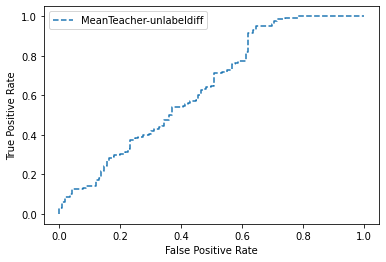

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6788321167883211
precision_true: 0.6685082872928176
precision_fake: 0.6989247311827957
recall_true: 0.8120805369127517
recall_fake: 0.52
f1score_true: 0.7333333333333334
f1score_fake: 0.5963302752293578
Binary_loss 0.83041847
*******TEACHER*************
accuracy: 0.656934306569343
precision_true: 0.6190476190476191
precision_fake: 0.8604651162790697
recall_true: 0.959731543624161
recall_fake: 0.296
f1score_true: 0.7526315789473684
f1score_fake: 0.44047619047619047
Binary_loss 0.65388787
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.677007299270073
precision_true: 0.6384439359267735
precision_fake: 0.8288288288288288
recall_true: 0.9362416107382551
recall_fake: 0.368
f1score_true: 0.7591836734693879
f1score_fake: 0.5096952908587258
Binary_loss 0.6608403
*******TEACHER*************
accuracy: 0.656934306569343
precision_true: 0.6195652173913043
precision_fake: 

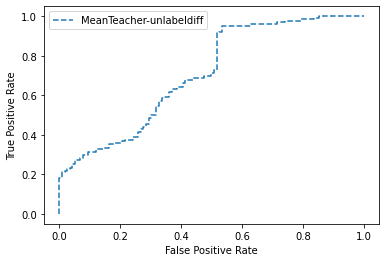

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6295620437956204
precision_true: 0.6479750778816199
precision_fake: 0.6035242290748899
recall_true: 0.697986577181208
recall_fake: 0.548
f1score_true: 0.6720516962843295
f1score_fake: 0.5744234800838576
Binary_loss 0.7093939
*******TEACHER*************
accuracy: 0.6861313868613139
precision_true: 0.6492890995260664
precision_fake: 0.8095238095238095
recall_true: 0.9194630872483222
recall_fake: 0.408
f1score_true: 0.7611111111111112
f1score_fake: 0.5425531914893618
Binary_loss 0.6642865
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6788321167883211
precision_true: 0.6713483146067416
precision_fake: 0.6927083333333334
recall_true: 0.802013422818792
recall_fake: 0.532
f1score_true: 0.7308868501529051
f1score_fake: 0.6018099547511312
Binary_loss 1.0685948
*******TEACHER*************
accuracy: 0.6843065693430657
precision_true: 0.6506024096385542
precision_fake: 

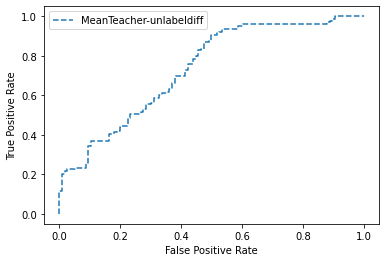

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.593065693430657
precision_true: 0.9310344827586207
precision_fake: 0.5292841648590022
recall_true: 0.27181208053691275
recall_fake: 0.976
f1score_true: 0.42077922077922075
f1score_fake: 0.6863572433192687
Binary_loss 1.1154855
*******TEACHER*************
accuracy: 0.6843065693430657
precision_true: 0.6582278481012658
precision_fake: 0.7516339869281046
recall_true: 0.87248322147651
recall_fake: 0.46
f1score_true: 0.7503607503607505
f1score_fake: 0.5707196029776676
Binary_loss 0.8221218
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5967153284671532
precision_true: 0.8347826086956521
precision_fake: 0.5334872979214781
recall_true: 0.3221476510067114
recall_fake: 0.924
f1score_true: 0.4648910411622275
f1score_fake: 0.6764275256222548
Binary_loss 1.0007379
*******TEACHER*************
accuracy: 0.6496350364963503
precision_true: 0.7208333333333333
precision_fake: 

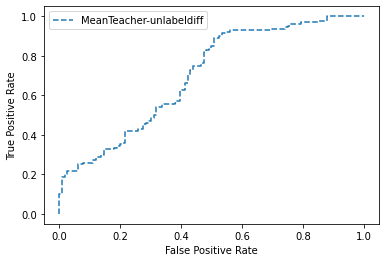

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6076642335766423
precision_true: 0.9368421052631579
precision_fake: 0.5386313465783664
recall_true: 0.2986577181208054
recall_fake: 0.976
f1score_true: 0.4529262086513995
f1score_fake: 0.6941678520625889
Binary_loss 1.0205206
*******TEACHER*************
accuracy: 0.6076642335766423
precision_true: 0.946236559139785
precision_fake: 0.5384615384615384
recall_true: 0.2953020134228188
recall_fake: 0.98
f1score_true: 0.4501278772378517
f1score_fake: 0.6950354609929078
Binary_loss 0.9805997
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6879562043795621
precision_true: 0.6666666666666666
precision_fake: 0.7365269461077845
recall_true: 0.8523489932885906
recall_fake: 0.492
f1score_true: 0.748159057437408
f1score_fake: 0.5899280575539568
Binary_loss 0.9955711
*******TEACHER*************
accuracy: 0.6076642335766423
precision_true: 0.946236559139785
precision_fake: 0.

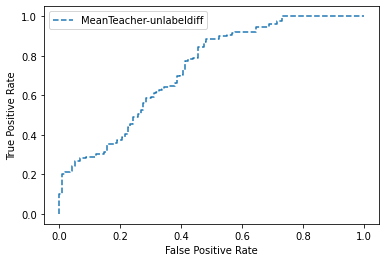

-----------------------------------------------------------------
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1129 1060
Test Label count : True, Fake 130 114
Train Mean teacher Model...
26/26 [==============================] - 11s 420ms/step - loss: 0.6918 - accuracy: 0.5570
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5072992700729927
precision_true: 0.7142857142857143
precision_fake: 0.50187265917603
recall_true: 0.036231884057971016
recall_fake: 0.9852941176470589
f1score_true: 0.06896551724137931
f1score_fake: 0.6650124069478909
Binary_loss 0.69281524
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.49635036496350365
precision_true: 0.0
precision_fake: 0.49635036496350365
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6634146341463415
Binary_loss 0.6926706
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5456204379562044
precision_true: 0.7647058823529411
precision_fake: 0.5231388329979879
recall_true: 0.14130434782608695
recall_fake: 0.9558823529411765
f1score_true: 0.2385321100917431
f1score_fake: 0.6762028608582575
Binary_loss 0.69163203
*******TEACHER*************
accuracy: 0.49635036496350365
precision_true: 0.0
precision_fake: 0.49635036496350365
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6634146341463415
Binary_loss 0.6929958
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5547445255474452
precision_true: 0.7580645161290323
precision_fake: 0.528806584362139

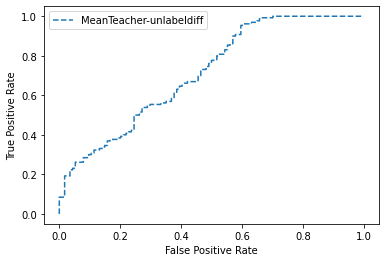

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6441605839416058
precision_true: 0.8785046728971962
precision_fake: 0.5873015873015873
recall_true: 0.34057971014492755
recall_fake: 0.9522058823529411
f1score_true: 0.4908616187989556
f1score_fake: 0.7265077138849929
Binary_loss 0.93893677
*******TEACHER*************
accuracy: 0.6295620437956204
precision_true: 0.9294117647058824
precision_fake: 0.5745140388768899
recall_true: 0.286231884057971
recall_fake: 0.9779411764705882
f1score_true: 0.43767313019390586
f1score_fake: 0.7238095238095238
Binary_loss 0.64674234
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5967153284671532
precision_true: 0.6045627376425855
precision_fake: 0.5894736842105263
recall_true: 0.5760869565217391
recall_fake: 0.6176470588235294
f1score_true: 0.5899814471243043
f1score_fake: 0.6032315978456013
Binary_loss 0.720385
*******TEACHER*************
accuracy: 0.6295620437956204
precisio

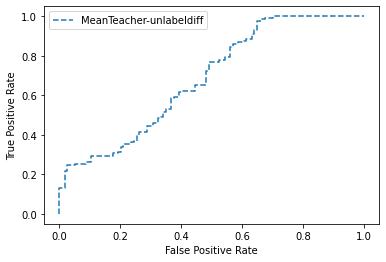

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6368613138686131
precision_true: 0.7730496453900709
precision_fake: 0.5896805896805897
recall_true: 0.39492753623188404
recall_fake: 0.8823529411764706
f1score_true: 0.5227817745803358
f1score_fake: 0.706921944035346
Binary_loss 1.245886
*******TEACHER*************
accuracy: 0.5894160583941606
precision_true: 0.6049382716049383
precision_fake: 0.5770491803278689
recall_true: 0.532608695652174
recall_fake: 0.6470588235294118
f1score_true: 0.5664739884393064
f1score_fake: 0.6100519930675911
Binary_loss 0.6024927
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6259124087591241
precision_true: 0.6141479099678456
precision_fake: 0.6413502109704642
recall_true: 0.6920289855072463
recall_fake: 0.5588235294117647
f1score_true: 0.6507666098807494
f1score_fake: 0.5972495088408645
Binary_loss 1.0567118
*******TEACHER*************
accuracy: 0.5948905109489051
precision_tr

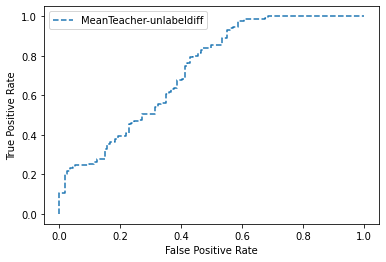

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5967153284671532
precision_true: 0.6104417670682731
precision_fake: 0.5852842809364549
recall_true: 0.5507246376811594
recall_fake: 0.6433823529411765
f1score_true: 0.5790476190476191
f1score_fake: 0.6129597197898425
Binary_loss 0.86203814
*******TEACHER*************
accuracy: 0.6131386861313869
precision_true: 0.6134751773049646
precision_fake: 0.6127819548872181
recall_true: 0.6268115942028986
recall_fake: 0.5992647058823529
f1score_true: 0.6200716845878136
f1score_fake: 0.6059479553903345
Binary_loss 0.80745155
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6113138686131386
precision_true: 0.6053511705685619
precision_fake: 0.6184738955823293
recall_true: 0.6557971014492754
recall_fake: 0.5661764705882353
f1score_true: 0.6295652173913044
f1score_fake: 0.5911708253358926
Binary_loss 0.7311918
*******TEACHER*************
accuracy: 0.6131386861313869
precisio

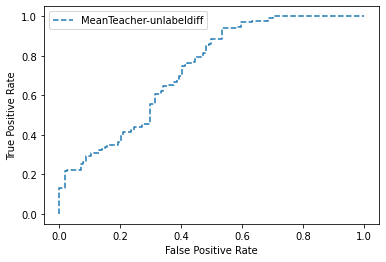

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6222627737226277
precision_true: 0.8108108108108109
precision_fake: 0.5743707093821511
recall_true: 0.32608695652173914
recall_fake: 0.9227941176470589
f1score_true: 0.46511627906976744
f1score_fake: 0.7080394922425953
Binary_loss 1.7582893
*******TEACHER*************
accuracy: 0.6277372262773723
precision_true: 0.6894736842105263
precision_fake: 0.5949720670391061
recall_true: 0.4746376811594203
recall_fake: 0.7830882352941176
f1score_true: 0.5622317596566524
f1score_fake: 0.6761904761904761
Binary_loss 1.0051337
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6204379562043796
precision_true: 0.8090909090909091
precision_fake: 0.5730593607305936
recall_true: 0.322463768115942
recall_fake: 0.9227941176470589
f1score_true: 0.4611398963730571
f1score_fake: 0.7070422535211267
Binary_loss 1.8920888
*******TEACHER*************
accuracy: 0.6186131386861314
precision

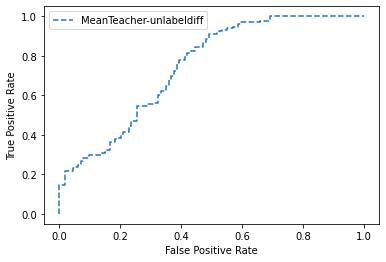

-----------------------------------------------------------------
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Train Mean teacher Model...
26/26 [==============================] - 11s 419ms/step - loss: 0.6925 - accuracy: 0.5229
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5127737226277372
precision_true: 0.71875
precision_fake: 0.5
recall_true: 0.08185053380782918
recall_fake: 0.9662921348314607
f1score_true: 0.14696485623003197
f1score_fake: 0.6590038314176245
Binary_loss 0.69128376
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.48722627737226276
precision_true: 0.0
precision_fake: 0.48722627737226276
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6552147239263804
Binary_loss 0.6919657
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5529197080291971
precision_true: 0.5782608695652174
precision_fake: 0.5345911949685535
recall_true: 0.47330960854092524
recall_fake: 0.6367041198501873
f1score_true: 0.5205479452054794
f1score_fake: 0.5811965811965812
Binary_loss 0.6898587
*******TEACHER*************
accuracy: 0.48722627737226276
precision_true: 0.0
precision_fake: 0.48722627737226276
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6552147239263804
Binary_loss 0.6926269
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6076642335766423
precision_true: 0.5942857142857143
precision_fake: 0.6313131313131313

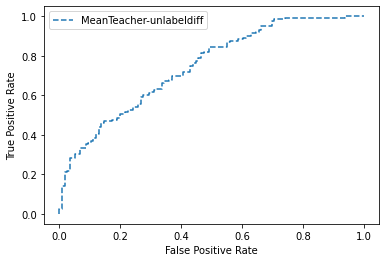

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6076642335766423
precision_true: 0.6398305084745762
precision_fake: 0.5833333333333334
recall_true: 0.5373665480427047
recall_fake: 0.6816479400749064
f1score_true: 0.5841392649903289
f1score_fake: 0.6286701208981001
Binary_loss 0.7509591
*******TEACHER*************
accuracy: 0.5967153284671532
precision_true: 0.8947368421052632
precision_fake: 0.548728813559322
recall_true: 0.24199288256227758
recall_fake: 0.9700374531835206
f1score_true: 0.38095238095238093
f1score_fake: 0.7009472259810554
Binary_loss 0.6479933
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5821167883211679
precision_true: 0.6065573770491803
precision_fake: 0.5625
recall_true: 0.5266903914590747
recall_fake: 0.6404494382022472
f1score_true: 0.5638095238095238
f1score_fake: 0.5989492119089317
Binary_loss 0.83024746
*******TEACHER*************
accuracy: 0.5985401459854015
precision_true: 0.90

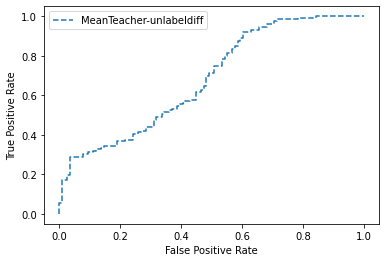

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6040145985401459
precision_true: 0.6185185185185185
precision_fake: 0.5899280575539568
recall_true: 0.594306049822064
recall_fake: 0.6142322097378277
f1score_true: 0.6061705989110707
f1score_fake: 0.601834862385321
Binary_loss 0.67996365
*******TEACHER*************
accuracy: 0.5492700729927007
precision_true: 0.5739130434782609
precision_fake: 0.5314465408805031
recall_true: 0.4697508896797153
recall_fake: 0.6329588014981273
f1score_true: 0.5166340508806262
f1score_fake: 0.5777777777777778
Binary_loss 0.6027902
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5875912408759124
precision_true: 0.5884244372990354
precision_fake: 0.5864978902953587
recall_true: 0.6512455516014235
recall_fake: 0.5205992509363296
f1score_true: 0.6182432432432432
f1score_fake: 0.5515873015873016
Binary_loss 0.8864095
*******TEACHER*************
accuracy: 0.5583941605839416
precision_t

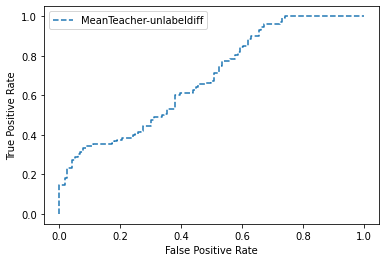

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6094890510948905
precision_true: 0.6254681647940075
precision_fake: 0.594306049822064
recall_true: 0.594306049822064
recall_fake: 0.6254681647940075
f1score_true: 0.6094890510948905
f1score_fake: 0.6094890510948905
Binary_loss 0.83990103
*******TEACHER*************
accuracy: 0.5802919708029197
precision_true: 0.6
precision_fake: 0.5631399317406144
recall_true: 0.5444839857651246
recall_fake: 0.6179775280898876
f1score_true: 0.5708955223880597
f1score_fake: 0.5892857142857143
Binary_loss 0.752632
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6058394160583942
precision_true: 0.6348547717842323
precision_fake: 0.5830618892508144
recall_true: 0.5444839857651246
recall_fake: 0.6704119850187266
f1score_true: 0.5862068965517241
f1score_fake: 0.6236933797909409
Binary_loss 1.0064027
*******TEACHER*************
accuracy: 0.5875912408759124
precision_true: 0.605363984

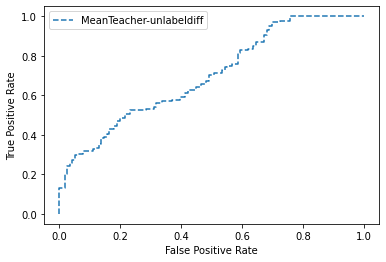

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6368613138686131
precision_true: 0.6529850746268657
precision_fake: 0.6214285714285714
recall_true: 0.6227758007117438
recall_fake: 0.651685393258427
f1score_true: 0.6375227686703095
f1score_fake: 0.6361974405850092
Binary_loss 0.68609595
*******TEACHER*************
accuracy: 0.6240875912408759
precision_true: 0.6383763837638377
precision_fake: 0.6101083032490975
recall_true: 0.6156583629893239
recall_fake: 0.6329588014981273
f1score_true: 0.6268115942028987
f1score_fake: 0.6213235294117647
Binary_loss 0.76768744
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.6438848920863309
precision_fake: 0.6222222222222222
recall_true: 0.6370106761565836
recall_fake: 0.6292134831460674
f1score_true: 0.6404293381037567
f1score_fake: 0.6256983240223464
Binary_loss 0.77644646
*******TEACHER*************
accuracy: 0.6295620437956204
precisio

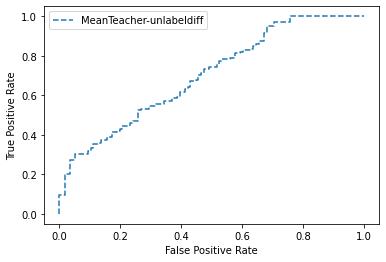

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1131 1059
Test Label count : True, Fake 128 115
Train Mean teacher Model...
26/26 [==============================] - 11s 419ms/step - loss: 0.6924 - accuracy: 0.5298
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5291970802919708
precision_true: 0.5646437994722955
precision_fake: 0.44970414201183434
recall_true: 0.6970684039087948
recall_fake: 0.3153526970954357
f1score_true: 0.6239067055393585
f1score_fake: 0.3707317073170731
Binary_loss 0.6901323
*******TEACHER*************
accuracy: 0.44343065693430656
precision_true: 0.6666666666666666
precision_fake: 0.44095940959409596
recall_true: 0.013029315960912053
recall_fake: 0.991701244813278
f1score_true: 0.025559105431309907
f1score_fake: 0.6104725415070243
Binary_loss 0.69172525
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5328467153284672
precision_true: 0.5648854961832062
precision_fake: 0.45161290322580644
recall_true: 0.7231270358306189
recall_fake: 0.29045643153526973
f1score_true: 0.6342857142857142
f1score_fake: 0.3535353535353536
Binary_loss 0.68912685
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4397810218978102
precision_true: 0.0
precision_fake: 0.4397810218978102
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6108998732572877
Binary_loss 0.69218165
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5291970802919708
precision_true: 0.5620253164556962
precision_fake: 0.4444444444444444
recall_true: 0.7231270358306189
recall_fake: 0.2821576763485477
f1score_true: 0.6324786324786325
f1score_fake: 0.3451776649746193
Binary_loss 0.6875479
*******TEACHER*************
accuracy: 0.4397810218978102
precision_true: 0.0
precision_fake: 0.4397810218978102
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6108998732572877
Binary_loss 0.69228995
* * * * * * * * * * * * * * * * *
Start of epoch 4
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.541970802919708
precision_true: 0.5696517412935324
precision_fake: 0.4657534246575342
rec

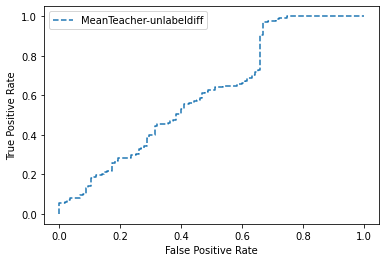

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5857664233576643
precision_true: 0.7409638554216867
precision_fake: 0.518324607329843
recall_true: 0.4006514657980456
recall_fake: 0.8215767634854771
f1score_true: 0.5200845665961945
f1score_fake: 0.6356340288924559
Binary_loss 0.8753166
*******TEACHER*************
accuracy: 0.6587591240875912
precision_true: 0.628755364806867
precision_fake: 0.8292682926829268
recall_true: 0.9543973941368078
recall_fake: 0.2821576763485477
f1score_true: 0.758085381630013
f1score_fake: 0.42105263157894735
Binary_loss 0.6398053
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6076642335766423
precision_true: 0.6619718309859155
precision_fake: 0.5492424242424242
recall_true: 0.6123778501628665
recall_fake: 0.6016597510373444
f1score_true: 0.6362098138747886
f1score_fake: 0.5742574257425742
Binary_loss 0.79171395
*******TEACHER*************
accuracy: 0.666058394160584
precision_tr

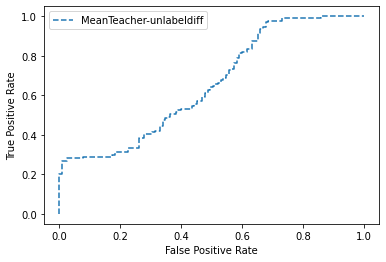

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6040145985401459
precision_true: 0.6461038961038961
precision_fake: 0.55
recall_true: 0.6482084690553745
recall_fake: 0.5477178423236515
f1score_true: 0.6471544715447155
f1score_fake: 0.5488565488565489
Binary_loss 0.7834276
*******TEACHER*************
accuracy: 0.6332116788321168
precision_true: 0.6373056994818653
precision_fake: 0.6234567901234568
recall_true: 0.8013029315960912
recall_fake: 0.4190871369294606
f1score_true: 0.70995670995671
f1score_fake: 0.501240694789082
Binary_loss 0.6181853
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5894160583941606
precision_true: 0.6814159292035398
precision_fake: 0.5248447204968945
recall_true: 0.501628664495114
recall_fake: 0.7012448132780082
f1score_true: 0.5778611632270169
f1score_fake: 0.6003552397868561
Binary_loss 0.9413388
*******TEACHER*************
accuracy: 0.6186131386861314
precision_true: 0.6408045977

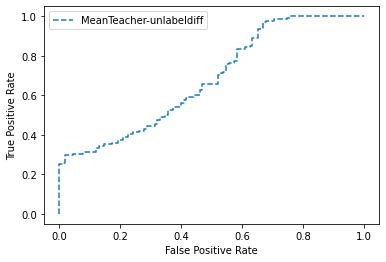

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6003649635036497
precision_true: 0.6349693251533742
precision_fake: 0.5495495495495496
recall_true: 0.6742671009771987
recall_fake: 0.5062240663900415
f1score_true: 0.6540284360189573
f1score_fake: 0.5269978401727862
Binary_loss 0.8454645
*******TEACHER*************
accuracy: 0.5967153284671532
precision_true: 0.6360759493670886
precision_fake: 0.5431034482758621
recall_true: 0.6547231270358306
recall_fake: 0.5228215767634855
f1score_true: 0.6452648475120385
f1score_fake: 0.53276955602537
Binary_loss 0.772309
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6204379562043796
precision_true: 0.6222222222222222
precision_fake: 0.6153846153846154
recall_true: 0.8208469055374593
recall_fake: 0.3651452282157676
f1score_true: 0.707865168539326
f1score_fake: 0.4583333333333333
Binary_loss 0.7425883
*******TEACHER*************
accuracy: 0.5948905109489051
precision_true

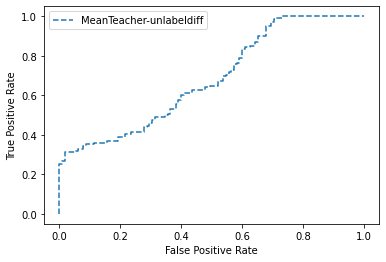

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5802919708029197
precision_true: 0.6287625418060201
precision_fake: 0.5220883534136547
recall_true: 0.6123778501628665
recall_fake: 0.5394190871369294
f1score_true: 0.6204620462046204
f1score_fake: 0.5306122448979592
Binary_loss 1.0059206
*******TEACHER*************
accuracy: 0.5948905109489051
precision_true: 0.6332288401253918
precision_fake: 0.5414847161572053
recall_true: 0.6579804560260586
recall_fake: 0.5145228215767634
f1score_true: 0.6453674121405751
f1score_fake: 0.5276595744680852
Binary_loss 0.8950053
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5875912408759124
precision_true: 0.6293929712460063
precision_fake: 0.5319148936170213
recall_true: 0.6416938110749185
recall_fake: 0.5186721991701245
f1score_true: 0.6354838709677418
f1score_fake: 0.5252100840336136
Binary_loss 1.1905619
*******TEACHER*************
accuracy: 0.5967153284671532
precision_

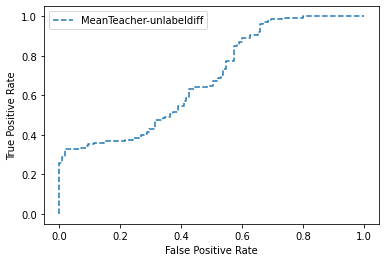

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Train Mean teacher Model...
26/26 [==============================] - 11s 426ms/step - loss: 0.6931 - accuracy: 0.5305
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.48175182481751827
precision_true: 0.7777777777777778
precision_fake: 0.47680890538033394
recall_true: 0.02422145328719723
recall_fake: 0.9922779922779923
f1score_true: 0.04697986577181208
f1score_fake: 0.6441102756892231
Binary_loss 0.6922358
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4726277372262774
precision_true: 0.0
precision_fake: 0.4726277372262774
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6418835192069392
Binary_loss 0.6930241
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.49635036496350365
precision_true: 1.0
precision_fake: 0.48411214953271026
recall_true: 0.04498269896193772
recall_fake: 1.0
f1score_true: 0.08609271523178808
f1score_fake: 0.6523929471032746
Binary_loss 0.6912539
*******TEACHER*************
accuracy: 0.4726277372262774
precision_true: 0.0
precision_fake: 0.4726277372262774
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6418835192069392
Binary_loss 0.693127
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5218978102189781
precision_true: 0.9655172413793104
precision_fake: 0.49710982658959535
recall_true: 0.096885813148788

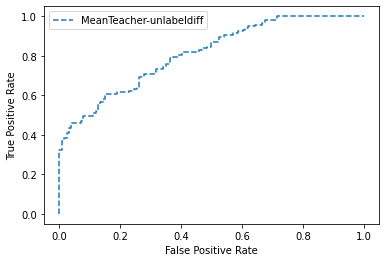

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6806569343065694
precision_true: 0.7065217391304348
precision_fake: 0.6544117647058824
recall_true: 0.6747404844290658
recall_fake: 0.6872586872586872
f1score_true: 0.6902654867256637
f1score_fake: 0.6704331450094162
Binary_loss 0.66963756
*******TEACHER*************
accuracy: 0.6441605839416058
precision_true: 0.8263888888888888
precision_fake: 0.5792079207920792
recall_true: 0.4117647058823529
recall_fake: 0.9034749034749034
f1score_true: 0.5496535796766744
f1score_fake: 0.7058823529411764
Binary_loss 0.6482534
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6113138686131386
precision_true: 0.625
precision_fake: 0.5942622950819673
recall_true: 0.657439446366782
recall_fake: 0.5598455598455598
f1score_true: 0.6408094435075885
f1score_fake: 0.5765407554671967
Binary_loss 0.6339338
*******TEACHER*************
accuracy: 0.6806569343065694
precision_true: 0.76635

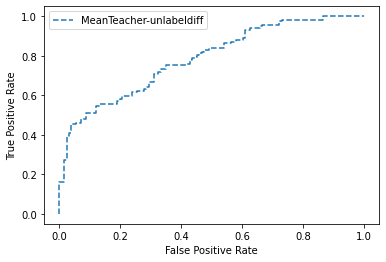

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6186131386861314
precision_true: 0.606951871657754
precision_fake: 0.6436781609195402
recall_true: 0.7854671280276817
recall_fake: 0.43243243243243246
f1score_true: 0.6847662141779789
f1score_fake: 0.5173210161662817
Binary_loss 0.90267015
*******TEACHER*************
accuracy: 0.6532846715328468
precision_true: 0.6181384248210023
precision_fake: 0.7674418604651163
recall_true: 0.8961937716262975
recall_fake: 0.38223938223938225
f1score_true: 0.731638418079096
f1score_fake: 0.5103092783505155
Binary_loss 0.56904405
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6295620437956204
precision_true: 0.612565445026178
precision_fake: 0.6686746987951807
recall_true: 0.8096885813148789
recall_fake: 0.42857142857142855
f1score_true: 0.6974664679582712
f1score_fake: 0.5223529411764706
Binary_loss 0.9725038
*******TEACHER*************
accuracy: 0.6259124087591241
precisio

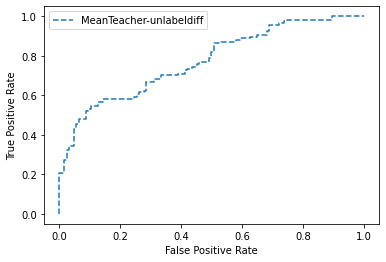

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6186131386861314
precision_true: 0.6063829787234043
precision_fake: 0.6453488372093024
recall_true: 0.7889273356401384
recall_fake: 0.42857142857142855
f1score_true: 0.6857142857142858
f1score_fake: 0.5150812064965197
Binary_loss 0.91362554
*******TEACHER*************
accuracy: 0.6240875912408759
precision_true: 0.6182336182336182
precision_fake: 0.6345177664974619
recall_true: 0.7508650519031141
recall_fake: 0.4826254826254826
f1score_true: 0.6781249999999999
f1score_fake: 0.5482456140350876
Binary_loss 0.73743224
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6204379562043796
precision_true: 0.6041131105398457
precision_fake: 0.660377358490566
recall_true: 0.8131487889273357
recall_fake: 0.40540540540540543
f1score_true: 0.6932153392330384
f1score_fake: 0.5023923444976076
Binary_loss 1.2275065
*******TEACHER*************
accuracy: 0.635036496350365
precisio

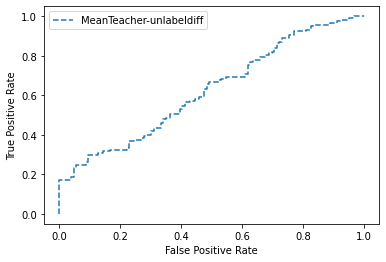

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.572992700729927
precision_true: 0.6211453744493393
precision_fake: 0.5389408099688473
recall_true: 0.48788927335640137
recall_fake: 0.667953667953668
f1score_true: 0.5465116279069768
f1score_fake: 0.596551724137931
Binary_loss 0.64615345
*******TEACHER*************
accuracy: 0.5547445255474452
precision_true: 0.6415094339622641
precision_fake: 0.519280205655527
recall_true: 0.35294117647058826
recall_fake: 0.7799227799227799
f1score_true: 0.4553571428571429
f1score_fake: 0.6234567901234568
Binary_loss 0.74421453
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5912408759124088
precision_true: 0.5981873111782477
precision_fake: 0.5806451612903226
recall_true: 0.6851211072664359
recall_fake: 0.4864864864864865
f1score_true: 0.6387096774193548
f1score_fake: 0.5294117647058824
Binary_loss 0.6274215
*******TEACHER*************
accuracy: 0.5620437956204379
precision_

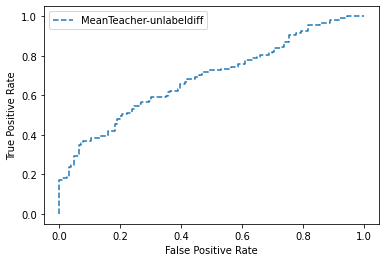

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Train Mean teacher Model...
26/26 [==============================] - 11s 425ms/step - loss: 0.6920 - accuracy: 0.5286
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5127737226277372
precision_true: 0.5090439276485789
precision_fake: 0.5217391304347826
recall_true: 0.718978102189781
recall_fake: 0.30656934306569344
f1score_true: 0.5960665658093798
f1score_fake: 0.38620689655172413
Binary_loss 0.69286495
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.5
precision_true: 0.0
precision_fake: 0.5
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6666666666666666
Binary_loss 0.692879
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5875912408759124
precision_true: 0.5530973451327433
precision_fake: 0.75
recall_true: 0.9124087591240876
recall_fake: 0.26277372262773724
f1score_true: 0.6887052341597796
f1score_fake: 0.38918918918918916
Binary_loss 0.6927179
*******TEACHER*************
accuracy: 0.5
precision_true: 0.0
precision_fake: 0.5
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6666666666666666
Binary_loss 0.6930657
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6021897810218978
precision_true: 0.5585774058577406
precision_fake: 0.9
recall_true: 0.9744525547445255
recall_fake: 0.22992700729927007
f1score_true: 0.71010638297

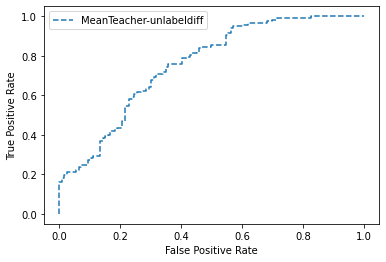

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6624087591240876
precision_true: 0.6977777777777778
precision_fake: 0.6377708978328174
recall_true: 0.572992700729927
recall_fake: 0.7518248175182481
f1score_true: 0.6292585170340682
f1score_fake: 0.6901172529313233
Binary_loss 0.6920926
*******TEACHER*************
accuracy: 0.6441605839416058
precision_true: 0.6405693950177936
precision_fake: 0.6479400749063671
recall_true: 0.656934306569343
recall_fake: 0.6313868613138686
f1score_true: 0.6486486486486487
f1score_fake: 0.6395563770794824
Binary_loss 0.6612762
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6459854014598541
precision_true: 0.6142857142857143
precision_fake: 0.702020202020202
recall_true: 0.7846715328467153
recall_fake: 0.5072992700729927
f1score_true: 0.6891025641025641
f1score_fake: 0.5889830508474576
Binary_loss 0.6803872
*******TEACHER*************
accuracy: 0.6459854014598541
precision_tru

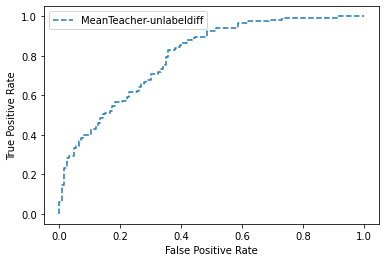

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6204379562043796
precision_true: 0.65
precision_fake: 0.600609756097561
recall_true: 0.5218978102189781
recall_fake: 0.718978102189781
f1score_true: 0.5789473684210527
f1score_fake: 0.654485049833887
Binary_loss 0.95132136
*******TEACHER*************
accuracy: 0.6313868613138686
precision_true: 0.7903225806451613
precision_fake: 0.5849056603773585
recall_true: 0.35766423357664234
recall_fake: 0.9051094890510949
f1score_true: 0.4924623115577889
f1score_fake: 0.7106017191977079
Binary_loss 0.6190368
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6222627737226277
precision_true: 0.679144385026738
precision_fake: 0.592797783933518
recall_true: 0.4635036496350365
recall_fake: 0.781021897810219
f1score_true: 0.5509761388286334
f1score_fake: 0.6740157480314961
Binary_loss 0.6733296
*******TEACHER*************
accuracy: 0.6222627737226277
precision_true: 0.8130841121

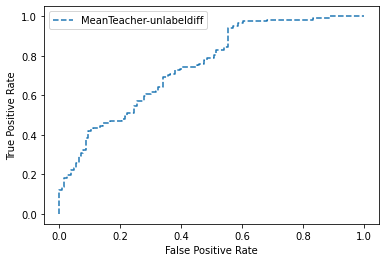

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6332116788321168
precision_true: 0.6298932384341637
precision_fake: 0.6367041198501873
recall_true: 0.6459854014598541
recall_fake: 0.6204379562043796
f1score_true: 0.6378378378378378
f1score_fake: 0.6284658040665434
Binary_loss 1.1990055
*******TEACHER*************
accuracy: 0.6423357664233577
precision_true: 0.7407407407407407
precision_fake: 0.6010362694300518
recall_true: 0.43795620437956206
recall_fake: 0.8467153284671532
f1score_true: 0.5504587155963302
f1score_fake: 0.7030303030303031
Binary_loss 0.92828614
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6131386861313869
precision_true: 0.5911764705882353
precision_fake: 0.6490384615384616
recall_true: 0.7335766423357665
recall_fake: 0.4927007299270073
f1score_true: 0.6547231270358306
f1score_fake: 0.5601659751037344
Binary_loss 1.4158727
*******TEACHER*************
accuracy: 0.6459854014598541
precisio

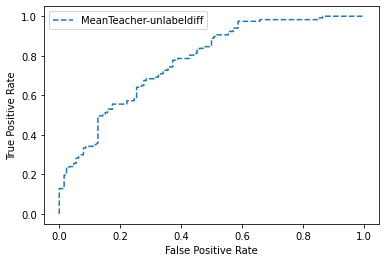

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.6441605839416058
precision_true: 0.6215384615384615
precision_fake: 0.6771300448430493
recall_true: 0.7372262773722628
recall_fake: 0.551094890510949
f1score_true: 0.674457429048414
f1score_fake: 0.6076458752515091
Binary_loss 1.7049189
*******TEACHER*************
accuracy: 0.6277372262773723
precision_true: 0.6047904191616766
precision_fake: 0.6635514018691588
recall_true: 0.7372262773722628
recall_fake: 0.5182481751824818
f1score_true: 0.6644736842105262
f1score_fake: 0.5819672131147541
Binary_loss 1.3834968
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6222627737226277
precision_true: 0.6401673640167364
precision_fake: 0.6084142394822006
recall_true: 0.5583941605839416
recall_fake: 0.6861313868613139
f1score_true: 0.5964912280701755
f1score_fake: 0.6449399656946827
Binary_loss 1.2333219
*******TEACHER*************
accuracy: 0.6277372262773723
precision_tr

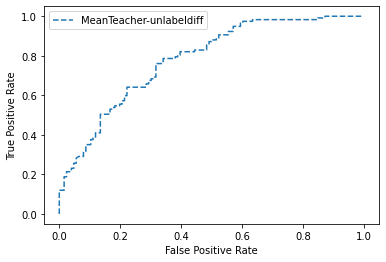

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1144 1046
Test Label count : True, Fake 115 128
Train Mean teacher Model...
26/26 [==============================] - 11s 423ms/step - loss: 0.6918 - accuracy: 0.5311
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.99
*******STUDENT*************
accuracy: 0.5091240875912408
precision_true: 0.5131578947368421
precision_fake: 0.5040983606557377
recall_true: 0.5631768953068592
recall_fake: 0.45387453874538747
f1score_true: 0.5370051635111877
f1score_fake: 0.47766990291262135
Binary_loss 0.6920831
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.49452554744525545
precision_true: 0.0
precision_fake: 0.49452554744525545
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6617826617826618
Binary_loss 0.69284266
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5547445255474452
precision_true: 0.5428571428571428
precision_fake: 0.5828220858895705
recall_true: 0.7545126353790613
recall_fake: 0.3505535055350554
f1score_true: 0.6314199395770392
f1score_fake: 0.4377880184331797
Binary_loss 0.6910851
*******TEACHER*************
accuracy: 0.49452554744525545
precision_true: 0.0
precision_fake: 0.49452554744525545
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6617826617826618
Binary_loss 0.69313526
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6167883211678832
precision_true: 0.5746102449888641
precision_fake: 0.808080808080808

In [ ]:
from sklearn.model_selection import KFold
if __name__ == '__main__':
 
    lr=0.0001
    epochs=30
    batch_size= 64
    #for mean teacher 
    ratio =0.5
    alpha=0.99 #(0.90-0.99)
    maxlen=100
    n_split=10
    x_train, y_train, x_test, y_test, x_unlabel = loading_data()
    x_train, x_test, x_unlabel, vocab_size, tokenizer = tokenization(x_train,x_test, x_unlabel, maxlen)
    X = np.concatenate((x_train, x_test))
    Y = np.concatenate((y_train, y_test))
  
    
    for train_index,test_index in KFold(n_split).split(X):
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        print("train Data_Size:",  np.shape(x_train))
        print("test Data_Size:",  np.shape(x_test))
        print('Train Label count: True, Fake', np.count_nonzero(y_train==1),np.count_nonzero(y_train==0))
        print('Test Label count : True, Fake', np.count_nonzero(y_test==1),np.count_nonzero(y_test==0))
        meanteacher=train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel,vocab_size, tokenizer,maxlen)
        # model=train_supervised(epochs,batch_size,lr,x_train,y_train,x_test,y_test,maxlen,vocab_size)

        tf.keras.backend.clear_session()
    

    print('finished')